https://github.com/gbrammer/eazy-py/blob/master/docs/examples/HDFN-demo.ipynb  
https://github.com/gbrammer/eazy-py

In [1]:
%matplotlib inline
import os
os.environ['EAZYCODE'] = 'usr/local/share/python/eazy-py/eazy-photoz'

import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 
    

# Module versions
import importlib
import sys
import time
print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    #print(module)
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = usr/local/share/python/eazy-py/eazy-photoz
Tue Jun 21 22:58:43 2022

3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:43:32) [Clang 12.0.1 ]

               numpy : 1.22.4
               scipy : 1.8.1
          matplotlib : 3.5.2
             astropy : 5.1
                eazy : 0.5.2.dev50
            prospect : 1.1.0


In [2]:
# quiet numpy/astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

EAZY translate file has 2 columns:
1) column label in your catalog  
2) filter line number in EAZY filter list prepended with:  
   "F"  for flux in uJy   
   "EF" for flux uncertainty in uJy
   
or "id" for id number; "z_spec" for spectroscopic redshift

NIRCam filters start on line 362:  
https://github.com/gbrammer/eazy-photoz/blob/cdd4510dbc32d828334f8d0b2e88652894a54653/filters/FILTER.RES.latest.info#L362

You might only have to set this up once.

In [3]:
# Input catalog csv with flux in uJy
field = 'ceers5'
inroot = field + '_photometry'
catalog_file = os.path.join('../phot3', inroot+'.csv')
translate_file = 'eazypy.translate.txt'
#translate_file = 'https://www.stsci.edu/~dcoe/eazypy.translate.txt'  # this doesn't work
output_file = field + '.eazypy'

In [4]:
# EAZY input parameters
# https://eazy-py.readthedocs.io/en/latest/_modules/eazy/photoz.html

params = {}
params['CATALOG_FILE'] = catalog_file
params['CATALOG_FORMAT'] = 'csv'

params['MAIN_OUTPUT_FILE'] = output_file

# Galactic extinction
params['MW_EBV'] = 0.0103
#params['MW_EBV'] = eazy.utils.get_irsa_dust(np.nanmedian(zf['ra']), np.nanmedian(zf['dec']))

params['CAT_HAS_EXTCORR'] = True

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 16.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 'f200w_flux' # K-band ~ F200W  # previously set to 28 255
params['PRIOR_FILE'] = 'templates/prior_K_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
#params['TEMPLATES_FILE'] = 'templates/spline_templates_v2/tweak_spline.param'

# FSPS + bluer templates added by Rebecca Larson 2022:
#params['TEMPLATES_FILE'] = 'templates/Larson22/tweak_fsps_QSF_12_v3_newtemplates_Lya_Reduced.param'  # general purpose
#params['TEMPLATES_FILE'] = 'templates/Larson22/tweak_fsps_QSF_12_v3_newtemplates.param'  # z > 8

params['FIX_ZSPEC'] = False

params['IGM_SCALE_TAU'] = 1.0

params['SYS_ERR'] = 0.03

In [5]:
# Initialize EAZY object
eazy_run = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None,
                              params=params, load_prior=True, load_products=False)

Read default param file: /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../phot3/ceers5_photometry.csv
   >>> NOBJ = 9755
f115w_flux f115w_fluxerr (364): jwst_nircam_f115w
f150w_flux f150w_fluxerr (365): jwst_nircam_f150w
f200w_flux f200w_fluxerr (366): jwst_nircam_f200w
f277w_flux f277w_fluxerr (375): jwst_nircam_f277w
f356w_flux f356w_fluxerr (376): jwst_nircam_f356w
f444w_flux f444w_fluxerr (377): jwst_nircam_f444w
Set sys_err = 0.03 (positive=True)
Read PRIOR_FILE:  templates/prior_K_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)


100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.63it/s]


Template   0: tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: tweak_fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: tweak_fsps_QSF_12_v3_012.dat (NZ=1).
Process templates: 8.112 s


283it [00:00, 1024.98it/s]


In [6]:
# Run EAZY SED fitting (takes a minute or two for thousands of objects)
eazy_run.fit_catalog(eazy_run.idx, n_proc=8)

100%|█████████████████████████████████████████| 283/283 [02:18<00:00,  2.04it/s]


Compute best fits
fit_best: 2.5 s (n_proc=1,  NOBJ=9369)
Fit 141.7 s (n_proc=8, NOBJ=9755)


In [7]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
# (takes another minute or two for thousands of objects)
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = eazy_run.standard_output(simple=False, 
                                 rf_pad_width=0.5, rf_max_err=2, 
                                 prior=True, beta_prior=True, 
                                 absmag_filters=[], 
                                 extra_rf_filters=[])

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 11.9 s (n_proc=1,  NOBJ=9466)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|███████████████████████████████████████| 9466/9466 [01:41<00:00, 92.85it/s]


In [17]:
# https://eazy-py.readthedocs.io/en/latest/eazy/zout_columns.html

# The risk R(zphot) can be roughly interpreted as the probability of the inferred redshift zphot being an outlier
# Tanaka et al. 2018: https://academic.oup.com/pasj/article/70/SP1/S9/4494086

zout.columns

<TableColumns names=('id','ra','dec','nusefilt','z_ml','z_ml_chi2','z_ml_risk','lc_min','lc_max','z_phot','z_phot_chi2','z_phot_risk','z_min_risk','min_risk','z_raw_chi2','raw_chi2','z025','z160','z500','z840','z975','restU','restU_err','restB','restB_err','restV','restV_err','restJ','restJ_err','dL','Lv','mass','sfr','LIR','energy_abs','Av','lw_age_V','MLv','Lv_p','mass_p','LIR_p','sfr_p','Av_p','ssfr_p')>

In [ ]:
# Saves a massive ~500MB file with everything
# (I'd rather rerun EAZY than save such a large file)
if 0:
    try:
        import h5py
    except:
        ! pip install h5py

    import eazy.hdf5
    #eazy.hdf5.write_hdf5(self, h5file=self.param['MAIN_OUTPUT_FILE'] + '.h5')

In [8]:
if not os.path.exists('plots'):
    os.makedirs('plots')
    
if not os.path.exists('plots/zspec'):
    os.makedirs('plots/zspec')

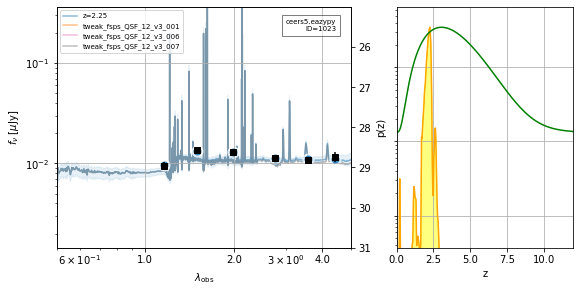

In [10]:
# https://eazy-py.readthedocs.io/en/latest/_modules/eazy/photoz.html
id = 1023
fig, data = eazy_run.show_fit(id, xlim=[0.5, 5], show_fnu=True, maglim=(31,25), 
                          show_components=True, logpz=True, zr=[0,12], show_prior=True)
fig.savefig('plots/eazy_%d.png' % id, dpi=300)

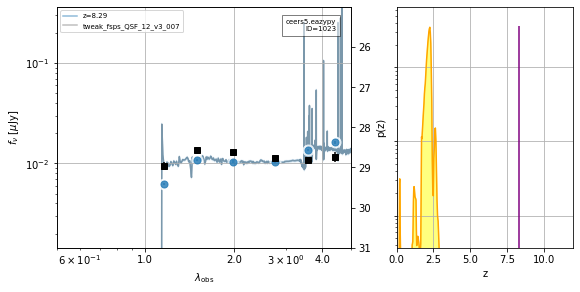

In [11]:
# Show best SED fit to the input spec-z
zspec = 8.292
fig, data = eazy_run.show_fit(id, xlim=[0.5, 5], show_fnu=True, maglim=(31,25), 
                          zshow=zspec,  # show best SED fit to the input spec-z
                          show_components=True, logpz=True, zr=[0,12], show_prior=False)
fig.savefig('plots/zspec/eazy_zspec_%d.png' % id, dpi=300)

# Combined output file: photometry + photo-z's

In [12]:
import astropy

In [13]:
#catalog = QTable.read(catalog_file)
catalog = astropy.io.ascii.read(catalog_file)

In [14]:
for label in zout.columns[3:]:
    #print(label)
    catalog[label] = zout[label]

In [15]:
outfile = field + '_phot-eazy.ecsv'
catalog.write(outfile, overwrite=True)

In [16]:
# Remove last 5 columns that give percentiles
# (could instead reformat into flat catalog if desired)
for label in list(catalog.columns):
    if label.endswith('_p'):
        catalog.remove_column(label)

outfile = field + '_phot-eazy.cat'
catalog.write(outfile, format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [ ]:
catalog